Notebook for working on updates to the code, independently form the updates on the trantor

In [7]:
import numpy as np
import halomod as hm
import hmf as hmf
import matplotlib.pyplot as plt
from hmf import cached_quantity, parameter, get_mdl
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import erfc
import os
    
from numba import njit, prange


In [17]:
os.environ['LD_LIBRARY_PATH'] = '/home/user/Documents/projects/UVLF_clust/MultiNest/MultiNest/lib/'

In [19]:
os.system('export LD_LIBRARY_PATH=/home/user/Documents/projects/UVLF_clust/MultiNest/MultiNest/lib/:$LD_LIBRARY_PATH')

0

In [21]:
os.system('echo $LD_LIBRARY_PATH')

/home/user/Documents/projects/UVLF_clust/MultiNest/MultiNest/lib/


0

In [22]:
import pymultinest


ERROR:   Could not load MultiNest library "libmultinest.so"
ERROR:   You have to build it first,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: https://johannesbuchner.github.io/PyMultiNest/install.html


ERROR:   Could not load MultiNest library: libmultinest.so
ERROR:   You have to build MultiNest,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: https://johannesbuchner.github.io/PyMultiNest/install.html

problem: libmultinest.so: cannot open shared object file: No such file or directory


SystemExit: 1

In [9]:
class Bias_nonlin(hm.bias.ScaleDepBias):
    def __init__(self, xi_dm: np.ndarray, nu: np.ndarray, z: float):
        self.xi_dm = xi_dm
        self.nu = nu
        self.z = z
        self.hmf_loc = hmf.MassFunction(self.z)
        super().__init__(self.xi_dm)

    def Mcol(self):
        """The nonlinear mass, nu(Mstar) = 1."""

        nu = spline(
            np.sqrt(self.hmf_loc.nu),
            #self.hmf_loc.delta_c / self.hmf_loc.sigma,
            self.hmf_loc.m,
            k=5
        )
        return nu(1)

    def Mnl(self):
        nu = spline(
            np.sqrt(self.hmf_loc.nu),
            #self.hmf_loc.delta_c / self.hmf_loc.sigma,
            self.hmf_loc.m,
            k=5
        )
        return nu(self.hmf_loc.delta_c)

    def bias_scale(self):
        K0 = -0.0697
        k1 = 1.1682
        k2 = 4.7577
        k3 = -0.1561
        L0 = 5.1447
        l1 = 1.4023
        l2 = 0.5823
        l3 = -0.1030
        alphaM = np.log10(self.hmf_loc.delta_c) / np.log10( self.Mnl() / self.Mcol()) 
        print(alphaM, np.log10( self.Mnl() / self.Mcol()))
        bias = (
            1 + K0 * np.log10(
                1+(self.xi_dm[:,np.newaxis])**k1
            ) * ((np.sqrt(self.nu)[np.newaxis,:]) ** k2) * (1 + k3 / alphaM)
        ) * (
            1 + L0 * np.log10(
                1+(self.xi_dm[:,np.newaxis])**l1
            ) * ((np.sqrt(self.nu)[np.newaxis,:]) ** l2) * (1 + l3 / alphaM)
        )
        # print(bias)
        # print(bias[100,100])
        return bias

In [10]:
class AngularCF_NL(hm.AngularCF):
    
    
    @parameter("model")
    def sd_bias_model(self, val):
        """Model of Scale Dependant Bias."""
        print("Here we are")
        if val is None:
            return None
        else:
            return get_mdl(val, "ScaleDepBias")

    @parameter("param")
    def sd_bias_params(self, val):
        """Dictionary of parameters for Scale Dependant Bias."""
        return val

    @cached_quantity
    def sd_bias(self):
        """A class containing relevant methods to calculate scale-dependent bias corrections."""
        print(self.sd_bias_model)
        if self.sd_bias_model is None:
            return None
        else:
            print(issubclass(self.sd_bias_model,Bias_nonlin))
            if issubclass(self.sd_bias_model,Bias_nonlin):
                return self.sd_bias_model(
                    xi_dm=self.corr_halofit_mm_fnc(self._r_table), nu=self.nu, **self.sd_bias_params
                )
            return self.sd_bias_model(
                self.corr_halofit_mm_fnc(self._r_table), **self.sd_bias_params
            )

    @cached_quantity
    def sd_bias_correction(self):
        """Return the correction for scale dependancy of bias."""
        print("Starting correction")
        if self.sd_bias is not None:
            return self.sd_bias.bias_scale()
        else:
            return None

    @cached_quantity
    def _tracer_exclusion(self):
        densityfunc = self.dndm[self._tm] * self.total_occupation[self._tm] / self.mean_tracer_den

        if self.sd_bias_model is not None:
            print(self.sd_bias_model, issubclass(self.sd_bias_model,Bias_nonlin))
            if issubclass(self.sd_bias_model,Bias_nonlin):
                bias = (self.sd_bias_correction * self.halo_bias)[:, self._tm]
                
            else:
                bias = np.outer(self.sd_bias_correction, self.halo_bias)[:, self._tm]
        else:
            bias = self.halo_bias[self._tm]

        return self.exclusion_model(
            m=self.m[self._tm],
            density=densityfunc,
            power_integrand=densityfunc * self.tracer_profile_ukm[:, self._tm],
            bias=bias,
            r=self._r_table,
            halo_density=self.halo_overdensity_mean * self.mean_density0,
            **self.exclusion_params,
        )


In [6]:
ang_func = AngularCF_NL(
    zmin=8,
    zmax=10,
    theta_min = 10**-4.2,
    theta_max=10**-0.7,
    sd_bias_model=Bias_nonlin,
    sd_bias_params={'z':8},
)
reg = AngularCF_NL()

Here we are


/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/_internals/_framework.py:196: UserWarning: Your specified redshift (z=0.0) is not within your selection function, z=(8,10)
  obj = type.__call__(cls, *args, **kwargs)
/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


Here we are


/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/_internals/_framework.py:196: UserWarning: Your specified redshift (z=0.0) is not within your selection function, z=(0.2,0.4)
  obj = type.__call__(cls, *args, **kwargs)


In [4]:

@njit(parallel=True)
def w_IC(ang_theta, ang_func,x_deg, y_deg, angular_distance):
    print(x_deg, y_deg)
    N_samples = int(1e7)
    x1 = np.random.uniform(
        -x_deg*angular_distance * 2*np.pi/360/ 2,
        x_deg*angular_distance * 2*np.pi/360 / 2,
        N_samples,
    )
    x2 = np.random.uniform(
        -x_deg*angular_distance * 2*np.pi/360/ 2,
        x_deg*angular_distance * 2*np.pi/360 / 2,
        N_samples,
    )
    y1 = np.random.uniform(
        -y_deg*angular_distance * 2*np.pi/360 / 2,
        y_deg*angular_distance * 2*np.pi/360 / 2,
        N_samples,
    )
    y2 = np.random.uniform(
        -y_deg*angular_distance * 2*np.pi/360 / 2,
        y_deg*angular_distance * 2*np.pi/360 / 2,
        N_samples,
    )

    integral_sum = 0.0
    for i in prange(N_samples):  # Parallel loop
        theta = np.sqrt(
            (x1[i]-x2[i])**2 + (y1[i] -y2[i])**2) / angular_distance
        integral_sum += 10**np.interp(
            np.log10(theta), np.log10(ang_theta), np.log10(ang_func))

    return integral_sum / N_samples


In [61]:
13*13 / 940.29997 / 940.29997 * 360**2 / 4 / np.pi**2

0.6274788976705542

In [ ]:
w_IC_instance = w_IC(ang_func.theta, ang_func.angular_corr_gal, 41.5/60,46.6/60,940.29997 )

0.6916666666666667 0.7766666666666667
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

In [63]:
6.373066651444351 * 2 * 5.675585108045933 * 2 / 940.29997 / 940.29997 * 360**2 / 4 / np.pi**2

0.5371944444444444

In [8]:
w_IC_instance

0.008138477377917227

In [90]:
w_IC_instance

0.0005990626755430917

In [81]:
41.5/60 * 46.6/60

0.5371944444444445

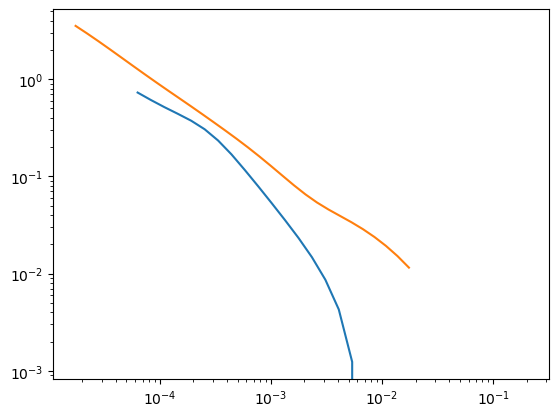

In [96]:
plt.plot(ang_func.theta, ang_func.angular_corr_gal - w_IC_instance)
plt.plot(reg.theta, reg.angular_corr_gal)

plt.xscale('log')
plt.yscale('log')

The updates from hereon come from mergin NL bias and corrected IC to all the work I've done previous week.

In [5]:
def ms_mh_flattening(mh, fstar_scale=1):
    """
        Get scaling relations for SHMR based on Davies+in prep.
        Parameters
        ----------
        mh: float,
            halo mass at which we're evaluating the relation.
        Returns
        ----------
        ms_mean: floats; optional,
            a and b coefficient of the relation.
    """
    f_star_mean = fstar_scale * 0.0076 * (2.6e11 / 1e10) ** 0.5
    f_star_mean /= (mh / 2.6e11) ** -0.5 + (mh / 2.6e11) ** 0.61
    return f_star_mean * mh
def ms_mh(ms, fstar_scale=1):
    mhs = np.logspace(5,15,500)
    mss = ms_mh_flattening(mhs, fstar_scale=fstar_scale)
    return 10**np.interp(np.log10(ms), np.log10(mss), np.log10(mhs))

In [6]:
class My_HOD(hm.hod.Zheng05):
    """
    Five-parameter model of Zheng (2005).

    Parameters
    ----------
    stellar_mass_min : float, default = 8.75
        Minimum mass of halo that supports a central galaxy
    stellar_mass_sigma: float, default = 0.3
    fstar_scale: float, default=1
    others: same as Zheng+05

    References
    ----------
    .. [1] Zheng, Z. et al., "Theoretical Models of the Halo Occupation Distribution:
           Separating Central and Satellite Galaxies ",
           https://ui.adsabs.harvard.edu/abs/2005ApJ...633..791Z.

    """

    _defaults = {
        'stellar_mass_min':8.75,
        'stellar_mass_sigma':0.05,
        'fstar_scale':1,
        'fstar_scale_sat':1,
        'stellar_mass_sigma_sat':0.3,
        'M1': 11.5,
        'alpha':0.50,
        'M_min':10.0,
        'sig_logm':0.05,
        'M_0':12.0,
        'M_1':13.0,
    }    

    def _central_occupation(self, m):
        """Amplitude of central tracer at mass M."""
        print(self.params["stellar_mass_sigma"])
        return 0.5 * erfc(
            -(
                np.log10(m)-np.log10(
                    ms_mh(10**self.params["stellar_mass_min"],
                          fstar_scale=self.params["fstar_scale"]
                         )
                )
            )/self.params["stellar_mass_sigma"] / np.sqrt(2)
        )
    
    def _satellite_occupation(self, m):
        """Amplitude of satellite tracer at mass M."""
        ns = np.zeros_like(m)
        ns_0 = np.zeros_like(m)
        
        ns_0[m > 10 ** self.params["M_0"]] = (
            (m[m > 10 ** self.params["M_0"]] - 10 ** self.params["M_0"]) / 10 ** self.params["M_1"]
        ) ** self.params["alpha"]
    
        ns[m > 10 ** self.params["M_0"]] = 0.5 * erfc(
                -(
                    np.log10(m[m > 10 ** self.params["M_0"]])-np.log10(
                        ms_mh(10**self.params["stellar_mass_min"],
                              fstar_scale=self.params["fstar_scale_sat"]
                             )
                    )
                )/self.params["stellar_mass_sigma_sat"] / np.sqrt(2)
            ) * (m[m > 10 ** self.params["M_0"]]/self.params["M1"])**self.params["alpha"]
            
        return ns


In [7]:
#FIDUCIALS
fid_params = {
    #'p1':lambda x: np.exp(-0.5*(x-9.25)**2/0.5**2),
    'zmin':8,
    'zmax':10.5,
    'theta_max':10**-0.8,
    'theta_min':10**-6.3,
    'theta_num':150,
    'theta_log':True,
    'hod_model':My_HOD,
    # 'hod_model': "Zheng05",
    'tracer_concentration_model':hm.concentration.Duffy08,
    'tracer_profile_model':hm.profiles.NFW,
    'hmf_model':"Behroozi",
    'bias_model':"Tinker10",
    'sd_bias_model':Bias_nonlin,
    'sd_bias_params':{'z':9.25},
}

In [8]:
angular_gal = AngularCF_NL(
    **fid_params,
    hod_params={
        'stellar_mass_min':8.75,
        'stellar_mass_sigma':0.3,
        'fstar_scale':1,
        'alpha':0.1,
        'M1':13.5,
        'stellar_mass_sigma_sat':0.5,
    }
    # hod_params={
    #     'M_min':10.9,
    #     'M_1':12.05,
    #     'alpha':0.73,
    #     'M_0':12.25,
    # }
)
w_IC_instance = w_IC(
    angular_gal.theta, 
    angular_gal.angular_corr_gal, 
    41.5/60,46.6/60,940.29997 
)

Here we are


/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/_internals/_framework.py:196: UserWarning: Your specified redshift (z=0.0) is not within your selection function, z=(8,10.5)
  obj = type.__call__(cls, *args, **kwargs)
/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


0.3


/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


0.3
0.3
<class '__main__.Bias_nonlin'> True
Starting correction
<class '__main__.Bias_nonlin'>
True
0.1864439438480041 1.2167601993748107


/tmp/ipykernel_35477/1187133113.py:42: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**k1
/tmp/ipykernel_35477/1187133113.py:46: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**l1
/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/halomod/tools.py:514: UserWarning: to use a power-law, y must be all positive or negative. Switching to zero extrapolation.
  self.ufunc = self._get_extension_func(


0.6916666666666667 0.7766666666666667


In [12]:
angular_gal_alpha03 = AngularCF_NL(
    **fid_params,
    hod_params={
        'stellar_mass_min':8.75,
        'stellar_mass_sigma':0.3,
        'fstar_scale':1,
        'alpha':0.3,
        'M1':13.5,
        'stellar_mass_sigma_sat':0.5,
    }
)
w_IC_instance_alpha03 = w_IC(
    angular_gal_alpha03.theta,
    angular_gal_alpha03.angular_corr_gal,
    41.5/60,46.6/60,940.29997 
)

Here we are


/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/_internals/_framework.py:196: UserWarning: Your specified redshift (z=0.0) is not within your selection function, z=(8,10.5)
  obj = type.__call__(cls, *args, **kwargs)
/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


0.3


/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


0.3
0.3
<class '__main__.Bias_nonlin'> True
Starting correction
<class '__main__.Bias_nonlin'>
True
0.1864439438480041 1.2167601993748107


/tmp/ipykernel_33471/1187133113.py:42: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**k1
/tmp/ipykernel_33471/1187133113.py:46: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**l1
/home/user/anaconda3/envs/UVLF_clust/lib/python3.13/site-packages/halomod/tools.py:514: UserWarning: to use a power-law, y must be all positive or negative. Switching to zero extrapolation.
  self.ufunc = self._get_extension_func(


0.6916666666666667 0.7766666666666667


In [13]:
angular_gal_scat08 = AngularCF_NL(
    **fid_params,
    hod_params={
        'stellar_mass_min':8.75,
        'stellar_mass_sigma':0.8,
        'fstar_scale':1,
        'alpha':0.1,
        'M1':13.5,
        'stellar_mass_sigma_sat':0.5,
    }
)
w_IC_instance_scat08 = w_IC(
    angular_gal_scat08.theta,
    angular_gal_scat08.angular_corr_gal,
    41.5/60,46.6/60,940.29997 
)

Here we are
0.8
0.8
0.8
<class '__main__.Bias_nonlin'> True
Starting correction
<class '__main__.Bias_nonlin'>
True
0.1864439438480041 1.2167601993748107


/tmp/ipykernel_33471/1187133113.py:42: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**k1
/tmp/ipykernel_33471/1187133113.py:46: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**l1


0.6916666666666667 0.7766666666666667


In [14]:
angular_gal_SHMR3 = AngularCF_NL(
    **fid_params,
    hod_params={
        'stellar_mass_min':8.75,
        'stellar_mass_sigma':0.3,
        'fstar_scale':0.3,
        'alpha':0.1,
        'M1':13.5,
        'stellar_mass_sigma_sat':0.5,
    }
    # hod_params={
    #     'M_min':10.9,
    #     'M_1':12.05,
    #     'alpha':0.73,
    #     'M_0':12.25,
    # }
)
w_IC_instance_SHMR3 = w_IC(
    angular_gal_SHMR3.theta, 
    angular_gal_SHMR3.angular_corr_gal, 
    41.5/60,46.6/60,940.29997 
)

Here we are
0.3
0.3
0.3
<class '__main__.Bias_nonlin'> True
Starting correction
<class '__main__.Bias_nonlin'>
True
0.1864439438480041 1.2167601993748107


/tmp/ipykernel_33471/1187133113.py:42: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**k1
/tmp/ipykernel_33471/1187133113.py:46: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**l1


0.6916666666666667 0.7766666666666667


In [15]:
angular_gal_M1 = AngularCF_NL(
    **fid_params,
    hod_params={
        'stellar_mass_min':8.75,
        'stellar_mass_sigma':0.3,
        'fstar_scale':1,
        'alpha':0.1,
        'M1':11.5,
        'stellar_mass_sigma_sat':0.5,
    }
    # hod_params={
    #     'M_min':10.9,
    #     'M_1':12.05,
    #     'alpha':0.73,
    #     'M_0':12.25,
    # }
)
w_IC_instance_M1 = w_IC(
    angular_gal_M1.theta, 
    angular_gal_M1.angular_corr_gal, 
    41.5/60,46.6/60,940.29997 
)

Here we are
0.3
0.3
0.3
<class '__main__.Bias_nonlin'> True
Starting correction
<class '__main__.Bias_nonlin'>
True
0.1864439438480041 1.2167601993748107


/tmp/ipykernel_33471/1187133113.py:42: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**k1
/tmp/ipykernel_33471/1187133113.py:46: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**l1


0.6916666666666667 0.7766666666666667


In [160]:
w_IC_instance = w_IC(angular_gal.theta, angular_gal.angular_corr_gal, 41.5/60,46.6/60,940.29997 )

0.3
0.3
0.3
<class '__main__.Bias_nonlin'> True
Starting correction
<class '__main__.Bias_nonlin'>
True
0.1864439438480041 1.2167601993748107


/tmp/ipykernel_16071/1187133113.py:42: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**k1
/tmp/ipykernel_16071/1187133113.py:46: RuntimeWarning: invalid value encountered in power
  1+(self.xi_dm[:,np.newaxis])**l1


0.6916666666666667 0.7766666666666667
6.373066651444351
5.675585108045933


In [161]:
w_IC_instance

0.014290548871521815

In [135]:
w_IC_instance_sgi1 = w_IC(angular_gal_sig1.theta, angular_gal_sig1.angular_corr_gal, 41.5/60,46.6/60,940.29997 )

0.6916666666666667 0.7766666666666667
6.373066651444351
5.675585108045933


In [136]:
w_IC_instance_sgi1

0.006124608302698378

In [16]:
dir_dat = "/home/user/Documents/projects/UVLF_clust/data/GalClustering_COSMOS-Web_Paquereau2025/clustering_measurements/"

In [17]:
cons_ndgal = [
    i.strip().split() for i in open(
        dir_dat + "clustresults_Paquereau2025_COSMOS-Web_FullSurvey_zbin8.0-10.5_conservative_ndgal.dat"
    ).readlines()
]
cons_theta = [
    i.strip().split() for i in open(
        dir_dat + "clustresults_Paquereau2025_COSMOS-Web_FullSurvey_zbin8.0-10.5_conservative_theta.dat"
    ).readlines()
]
cons_wtheta = [
    i.strip().split() for i in open(
        dir_dat + "clustresults_Paquereau2025_COSMOS-Web_FullSurvey_zbin8.0-10.5_conservative_wtheta.dat"
    ).readlines()
]
cons_wsig = [
    i.strip().split() for i in open(
        dir_dat + "clustresults_Paquereau2025_COSMOS-Web_FullSurvey_zbin8.0-10.5_conservative_wsig.dat"
    ).readlines()
]

thethats87_pos = [
    float(i) for i,j in zip(cons_theta[1],cons_wtheta[1]) if float(j)>0
]
wthethats87_pos = [
    float(i) for i,j in zip(cons_wtheta[1],cons_wtheta[1]) if float(j)>0
]
wsig87_pos = [
    float(i) for i,j in zip(cons_wsig[1],cons_wtheta[1]) if float(j)>0
]

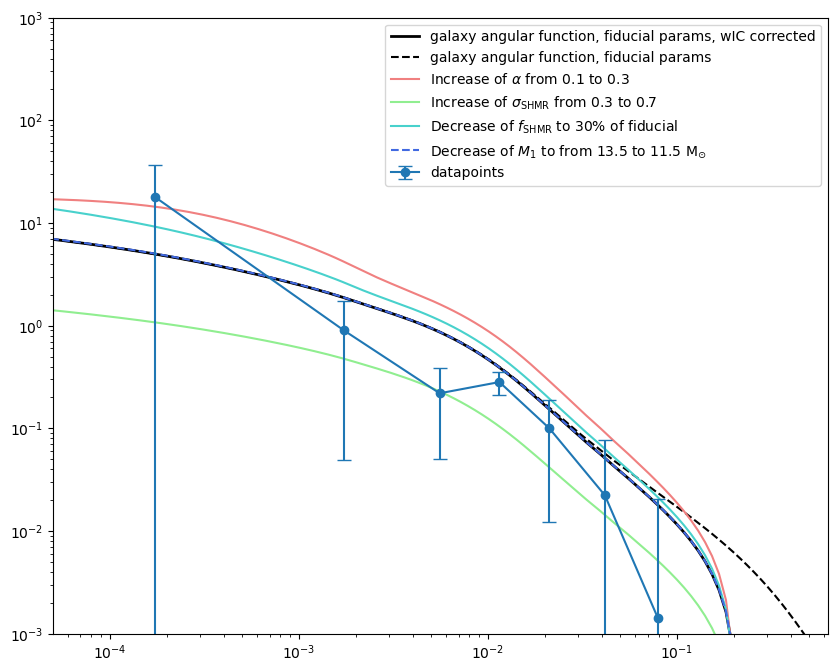

In [18]:
plt.figure(figsize=(10,8))

thetas = np.logspace(
        np.log10(angular_gal.theta_min),
        np.log10(angular_gal.theta_max),
        angular_gal.theta_num
    )/2/np.pi * 360
#thetas=angular_gal.theta*360/2/np.pi
plt.plot(
    thetas, 
    angular_gal.angular_corr_gal - w_IC_instance,
    label='galaxy angular function, fiducial params, wIC corrected',
    color='black',
    lw=2,
)


plt.plot(
    thetas, 
    angular_gal.angular_corr_gal,
    label='galaxy angular function, fiducial params',
    color='black',
    ls='--',
)
plt.plot(
    thetas, 
    angular_gal_alpha03.angular_corr_gal - w_IC_instance_alpha03,
    label=r'Increase of $\alpha$ from 0.1 to 0.3',
    color='lightcoral',
)

plt.plot(
    thetas, 
    angular_gal_scat08.angular_corr_gal - w_IC_instance_scat08,
    label=r'Increase of $\sigma_{\rm SHMR}$ from 0.3 to 0.7',
    color='lightgreen',
)
plt.plot(
    thetas, 
    angular_gal_SHMR3.angular_corr_gal - w_IC_instance_SHMR3,
    label=r'Decrease of $f_{\rm SHMR}$ to 30% of fiducial',
    color='mediumturquoise',
)
plt.plot(
    thetas, 
    angular_gal_M1.angular_corr_gal - w_IC_instance_M1,
    label=r'Decrease of $M_1$ to from 13.5 to 11.5 M$_{\odot}$',
    color='royalblue', ls='--',
)

plt.errorbar(
    thethats87_pos,
    wthethats87_pos,
    wsig87_pos,
    label='datapoints',
    marker='o',
    capsize=5.0,
)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**-4.3,10**-.2)
plt.ylim(10**-3,10**3)
plt.savefig('/home/user/Documents/projects/UVLF_clust/HOD_finished_params_var.pdf',bbox_inches='tight')

In [2]:
angular_gal.corr_1h_auto_matter

NameError: name 'angular_gal' is not defined

In [1]:
plt.figure(figsize=(10,8))

thetas = np.logspace(
        np.log10(angular_gal.theta_min),
        np.log10(angular_gal.theta_max),
        angular_gal.theta_num
    )/2/np.pi * 360
#thetas=angular_gal.theta*360/2/np.pi
plt.plot(
    thetas, 
    angular_gal.angular_corr_gal- w_IC_instance,
    label='galaxy angular function, fiducial params, wIC corrected',
    color='black',
    lw=2,
)
plt.plot(
    angular_gal.r /940.29997  , 
    angular_gal.corr_1h_auto_matter,
    label='galaxy angular function, fiducial params, wIC corrected',
    color='black',
    lw=2,
    ls='--',
)
plt.plot(
    angular_gal.r /940.29997  , 
    angular_gal.corr_2h_auto_matter,
    label='galaxy angular function, fiducial params, wIC corrected',
    color='black',
    lw=2,
    ls='.-',
)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**-4.3,10**-.2)
plt.ylim(10**-3,10**3)
plt.savefig(
    '/home/user/Documents/projects/UVLF_clust/HOD_finished_params_var.pdf',
    bbox_inches='tight'
)


NameError: name 'plt' is not defined

Updates with ultranest. Checking how the prior influences results and why the inference is so slow.

In [5]:
import numpy as np
import halomod as hm
import hmf as hmf
import matplotlib.pyplot as plt
from hmf import cached_quantity, parameter, get_mdl
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import erfc
import pymultinest
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from numba import njit, prange
import ultranest


hmf_loc = hmf.MassFunction(z=11)
def ms_mh_flattening(mh, fstar_scale = 1.0, alpha_star_low = 0.5):
    """
        Get scaling relations for SHMR based on Davies+in prep.
        Parameters
        ----------
        mh: float,
            halo mass at which we're evaluating the relation.
        Returns
        ----------
        ms_mean: floats; optional,
            a and b coefficient of the relation.
    """
    f_star_mean = fstar_scale * 0.0076 * (2.6e11 / 1e10) ** alpha_star_low
    f_star_mean /= (mh / 2.6e11) ** (-alpha_star_low) + (mh / 2.6e11) ** 0.61
    return f_star_mean * mh

def ms_mh(ms, fstar_scale=1, alpha_star_low=0.5):
    mhs = np.logspace(5,15,500)
    mss = ms_mh_flattening(mhs, fstar_scale=fstar_scale, alpha_star_low=alpha_star_low)
    return 10**np.interp(np.log10(ms), np.log10(mss), np.log10(mhs))

def SFMS(Mstar, SFR_norm = 1., z=9.25):
    """
        the functon returns SFR from Main sequence
    """
    b_SFR = -np.log10(0.43) + np.log10(cosmo.H(z).to(u.yr ** (-1)).value)

    return Mstar * 10 ** b_SFR * SFR_norm


def kUV(SFR):
    """
        Simplest transformation between SFR and Luv
    """
    return SFR / (1.15 * 1e-28)


def Muv_Luv(Luv):
    """
        Luv to Muv
    """
    return -2.5 * np.log10(Luv) + 51.6


def sigma_SFR_variable(Mstar, norm=0.18740570999999995, a_sig_SFR=-0.11654893):
    """
        Variable scatter of SFR-Mstar relation.
        It's based on FirstLight database.
    Parameters
    ----------
    Mstar: stellar mass at which the relation is taken

    Returns
    -------
    sigma: sigma of the relation
    """
    # a_sig_SFR = -0.11654893
    #b_sig_SFR = 1.35289501
    #     sigma = a_sig_SFR * np.log10(Mstar) + b_sig_SFR

    Mstar = np.asarray(Mstar)  # Convert input to a numpy array if not already

    sigma = a_sig_SFR * np.log10(Mstar/1e10) + norm
    sigma[Mstar > 10 ** 10] = norm

    return sigma + norm


#     if Mstar > 10**10:
#         return 0.18740570999999995 - norm
#     else:
#         return sigma - norm

@njit(parallel=True)
def uv_calc(
    Muv,
    masses_hmf,
    dndm,
    sigma_SFMS=0.1,
    sigma_SHMR=0.1,
    ms_obs_log = None,
    sfr_obs_log = None,
    msss=None,
    sfrs=None,
    muvs=None,
):
    #print(x_deg, y_deg)
    N_samples = int(1e4)
    log_mhs_int = np.random.uniform(
        7.0,
        14.0,
        N_samples,
    )
#     log_ms_int = np.random.uniform(
#         6.0,
#         12.0,
#         N_samples,
#     )
    #msss = np.interp(log_mhs_int, masses_hmf, np.log10(msss))

    log_ms_int = np.interp(log_mhs_int, masses_hmf, np.log10(msss))
    sig_int = np.interp(log_ms_int, np.log10(msss), sigma_SFMS)
    muvs_int = np.interp(log_mhs_int, masses_hmf, muvs)
    integral_sum = 0.0
    for i in prange(N_samples):  # Parallel loop
        dnd = np.interp(log_mhs_int[i], masses_hmf, dndm)
        ppred = 1 / np.sqrt(sig_int[i]**2 + sigma_SHMR**2) * np.sqrt(2)

#         print(dnd)
        #exp = np.exp(-(Muv-muvs_int[i])**2/2/(sigma_SFMS**2 + sigma_SHMR**2))
        exp = np.exp(-(log_ms_int[i]-ms_obs_log)**2/2/(sig_int[i]**2 + sigma_SHMR**2))
        integral_sum += dnd * ppred * exp
    return integral_sum / N_samples * 7


def UV_calc(
        Muv,
        masses_hmf,
        dndm,
        f_star_norm=1.0,
        alpha_star=0.5,
        sigma_SHMR=0.3,
        sigma_SFMS_norm=0.0,
        t_star=0.5,
        a_sig_SFR = -0.11654893
):
    msss = ms_mh_flattening(10**masses_hmf, alpha_star_low=alpha_star,
                            fstar_scale=f_star_norm)
    sfrs = SFMS(msss, SFR_norm=0.43 / t_star, z=11)
    muvs = Muv_Luv(kUV(sfrs))
    sfr_obs_log = np.interp(Muv, np.flip(muvs), np.flip(np.log10(sfrs)))
    ms_obs_log = np.interp(sfr_obs_log, np.log10(sfrs), np.log10(msss))
    sigma_SFMS_var = sigma_SFR_variable(msss, norm = sigma_SFMS_norm, a_sig_SFR=a_sig_SFR)
    uvlf = [uv_calc(
        muvi,
        masses_hmf,
        dndm,
        sigma_SFMS=sigma_SFMS_var,
        sigma_SHMR=sigma_SHMR,
        sfr_obs_log=sfr_obs_log[index],
        ms_obs_log=ms_obs_log[index],
        msss=msss,
        sfrs=sfrs,
        muvs=muvs,
    ) for index, muvi in enumerate(Muv)]

    return uvlf

# def like_UV(fi, asi, s_sfri,s_shmri, tsti):
#     McL_Muvs = np.array(
#         [-22.57,-21.80,-20.80,-20.05,-19.55,-18.85,-18.23]
#     )
#     McL_uvlf = np.array(
#         [0.012,0.128,1.251,3.951,9.713,23.490,63.080]
#     )*1e-5
#     Mcl_sig = np.array(
#         [0.010,0.128,0.424,1.319, 4.170,9.190,28.650]
#     )*1e-5
#     lnL = 0
#     preds = UV_calc(
#         McL_Muvs,
#         np.log10(hmf_loc.m),
#         hmf_loc.dndlnm,
#         f_star_norm=10**fi,
#         alpha_star=asi,
#         sigma_SHMR = s_shmri,
#         sigma_SFMS = s_sfri,
#         t_star = tsti,
#     )
#     for index, muvi in enumerate(McL_Muvs):
#         lnL += -0.5 * (((preds[index] - McL_uvlf[index]) / Mcl_sig[
#                 index]) ** 2)
#     return lnL


ERROR:   Could not load MultiNest library "libmultinest.so"
ERROR:   You have to build it first,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: https://johannesbuchner.github.io/PyMultiNest/install.html


ERROR:   Could not load MultiNest library: libmultinest.so
ERROR:   You have to build MultiNest,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: https://johannesbuchner.github.io/PyMultiNest/install.html

problem: libmultinest.so: cannot open shared object file: No such file or directory


SystemExit: 1

In [12]:
import numpy as np
import halomod as hm
import hmf as hmf
import time
import pymultinest
from astropy.cosmology import Planck18 as cosmo

import ultranest

from uvlf import UV_calc

from ulty import Bias_nonlin, AngularCF_NL, w_IC, My_HOD
from observations import Observations

class LikelihoodAngBase():
    """

    To be filled

    Returns
    -------

    """
    def __init__(self, params):
        fid_params = {
            'p1':lambda x: np.exp(-0.5*(x-9.25)**2/0.5**2),
            'zmin': 8,
            'zmax': 10.5,
            'theta_max': 10 ** -0.8,
            'theta_min': 10 ** -6.3,
            'theta_num': 50,
            'theta_log': True,
            'hod_model': My_HOD,
            'tracer_concentration_model': hm.concentration.Duffy08,
            'tracer_profile_model': hm.profiles.NFW,
            'hmf_model': "Behroozi",
            'bias_model': "Tinker10",
            'sd_bias_model': Bias_nonlin,
            'sd_bias_params': {'z': 9.25},
            'transfer_model': "EH",
            'rnum': 30,
            'rmin': 0.1,
            'rmax': 30,
            'dr_table': 0.1,
            'dlnk': 0.1,
            'dlog10m': 0.05,
        }
        self.params = params

        self.angular_gal = AngularCF_NL(
            **fid_params,
            hod_params={
                'stellar_mass_min': 8.75,
                'stellar_mass_sigma': 0.3,
                'fstar_scale': 10 ** 0.0,
                'alpha_star_low': 0.5,
                'alpha': 1.0,
                'M1': 13.5,
                'fstar_scale_sat': 10 ** 0,
                'stellar_mass_sigma_sat': 0.3,
            }
        )

    def call_likelihood(self, p, obs="Ang_z9_m87", thet = None, w = None, sig_w=None):
        dic_params = {}
        for index,pary in enumerate(self.params):
            dic_params[pary] = p[index]
        if "alpha" in dic_params:
            alpha = dic_params["alpha"]
        else:
            alpha = 1.0

        if "M_0" in dic_params:
            M_0 = dic_params["M_0"]
        else:
            M_0 = 12.0

        if "M_1" in dic_params:
            M_1 = dic_params["M_1"]
        else:
            M_1 = 13.5

        if "fstar_scale" in dic_params:
            fstar_scale = dic_params["fstar_scale"]
        else:
            fstar_scale = 10 ** 0.0

        if "sigma_SHMR" in dic_params:
            sigma_SHMR = dic_params["sigma_SHMR"]
        else:
            sigma_SHMR = 0.3

        if "alpha_star_low" in dic_params:
            alpha_star_low = dic_params["alpha_star_low"]
        else:
            alpha_star_low = 0.5

        if obs=="Ang_z9_m87":
            M_thresh = 8.75
        else:
            M_thresh = 9.0

        self.angular_gal.hod_params = {
            'stellar_mass_min': M_thresh,
            'stellar_mass_sigma': sigma_SHMR,
            'fstar_scale': 10 ** fstar_scale,
            'alpha': alpha,
            'alpha_star_low': alpha_star_low,
            'M1': M_1,
            'M_0': M_0,
        }
        ang_th = self.angular_gal.theta
        ang_ang = self.angular_gal.angular_corr_gal
        w_IC_instance = w_IC(
            ang_th,
            ang_ang,
            41.5 / 60, 46.6 / 60, 940.29997
        )
        like= 0
        for i_theta, ts in enumerate(thet):
            if ts>0.003:

                wi = np.interp(
                    ts,
                    ang_th / 2 / np.pi * 360,
                    ang_ang - w_IC_instance
                )
                # compare model and data with gaussian likelihood:
                like += -0.5 * (((wi - w[i_theta]) / sig_w[
                    i_theta]) ** 2)
        return like


class LikelihoodUVLFBase:
    """
    To be filled
    Returns
    -------

    """

    def __init__(self, params):
        self.hmf_loc = hmf.MassFunction(z=11)
        self.params = params

    def call_likelihood(self, p, muvs=None, uvlf=None, sig=None):
        # dic_params = dict.fromkeys(self.params, p)
        dic_params = {}
        for index, pary in enumerate(self.params):
            dic_params[pary] = p[index]

        if "fstar_scale" in dic_params:
            fstar_scale = dic_params["fstar_scale"]
        else:
            fstar_scale = 0.0

        if "sigma_SHMR" in dic_params:
            sigma_SHMR = dic_params["sigma_SHMR"]
        else:
            sigma_SHMR = 0.3

        if "sigma_SFMS_norm" in dic_params:
            sigma_SFMS_norm = dic_params["sigma_SFMS_norm"]
        else:
            sigma_SFMS_norm = 0.0

        if "t_star" in dic_params:
            t_star = dic_params["t_star"]
        else:
            t_star = 0.5

        if "alpha_star_low" in dic_params:
            alpha_star = dic_params["alpha_star_low"]
        else:
            alpha_star = 0.5

        if "a_sig_SFR" in dic_params:
            a_sig_SFR = dic_params["a_sig_SFR"]
        else:
            a_sig_SFR = -0.11654893

        lnL = 0
        preds = UV_calc(
            muvs,
            np.log10(self.hmf_loc.m),
            self.hmf_loc.dndlnm,
            f_star_norm=10 ** fstar_scale,
            alpha_star=alpha_star,
            sigma_SHMR=sigma_SHMR,
            sigma_SFMS_norm=sigma_SFMS_norm,
            t_star=t_star,
            a_sig_SFR=0.0,
        )

        for index, muvi in enumerate(muvs):
            lnL += -0.5 * (((preds[index] - uvlf[index]) / sig[
                index]) ** 2)
        return lnL

def run_mcmc(
        likelihoods,
        params,
        mult_params=None,
        priors=None,
):

    if priors is None:
        priors = [(-1.0,1.0),(0.0,1.0), (0.05,0.9), (0.01,1.0), (0.01,1.0)]
    #initialize likelihoods

    #if initialized
    mult_params_fid = {
        "use_MPI": True,
        "outputfiles_basename": "/home/inikolic/projects/UVLF_FMs/run_speed/run_mult_4/",
        "importance_nested_sampling": False,
        "sampling_efficiency": 0.8,
        "evidence_tolerance": 0.5,
        "multimodal": False,
        "n_iter_before_update": 20,
        'n_live_points': 200,
    }
    if mult_params is None:
        mult_params = mult_params_fid
    else:
        for key in mult_params_fid:
            if key not in mult_params:
                mult_params[key] = mult_params_fid[key]

    if "Ang_z9_m87" in likelihoods or "Ang_z9_m9" in likelihoods:
        ang = True
        AngBase = LikelihoodAngBase(params)
    else:
        ang = False
    if "UVLF_z11_McLeod23" in likelihoods:
        uvlf = True
        UVLFBase = LikelihoodUVLFBase(params)
    else:
        uvlf = False

    observations_inst = Observations(ang, uvlf)

    def likelihood(p, ndim, nparams, lnew):
        lnL = 0
        for li in likelihoods:
            if li == "Ang_z9_m87":
                thet, w, wsig = observations_inst.get_obs_z9_m87()
                lnL+=AngBase.call_likelihood(
                    p,
                    obs="Ang_z9_m87",
                    thet=thet,
                    w=w,
                    sig_w=wsig
                )
            elif li == "Ang_z9_m9":
                thet, w, wsig = observations_inst.get_obs_z9_m90()
                lnL+=AngBase.call_likelihood(
                    p,
                    obs="Ang_z9_m9",
                    thet=thet,
                    w=w,
                    sig_w=wsig
                )
            elif li == "UVLF_z11_McLeod23":
                muvs, uvlf, sig = observations_inst.get_obs_uvlf_z11_McLeod23()
                lnL+=UVLFBase.call_likelihood(
                    p,
                    muvs=muvs,
                    uvlf=uvlf,
                    sig=sig
                )
        return lnL


    def prior(cube, ndim, nparams):

        params = []
        for i in range(ndim):
            params.append( cube[i] * (priors[i][1]-priors[i][0]) + priors[i][0])
        cube = np.array(params).copy()
        return cube

    result = pymultinest.run(
        LogLikelihood=likelihood,
        Prior=prior,
        n_dims=len(params),
        **mult_params
    )




ERROR:   Could not load MultiNest library "libmultinest.so"
ERROR:   You have to build it first,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: https://johannesbuchner.github.io/PyMultiNest/install.html


ERROR:   Could not load MultiNest library: libmultinest.so
ERROR:   You have to build MultiNest,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: https://johannesbuchner.github.io/PyMultiNest/install.html

problem: libmultinest.so: cannot open shared object file: No such file or directory


SystemExit: 1